# MOVED TO SNAKEMAKE

In [1]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

from pathlib import Path

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
%load_ext autoreload
%autoreload 2
from utils import *

# scperturb package
sys.path.insert(1, '../../package/src/')
from scperturb import *

from pathlib import Path
figure_path = Path('../../figures/')

In [3]:
DATADIR = Path('/data/gpfs-1/users/peidlis_c/work/data/perturbation_resource_paper')
# show that the E-distance in its corrected form is less biased?
adata = sc.read(DATADIR / 'NormanWeissman2019_filtered.h5ad')

In [4]:
def subsampling(adata, obs_key, N):
    '''
    Subsample to same class sizes. Classes given by obs_key pointing to categorical in adata.obs.
    Discards any class with less than N entries.
    '''
    counts_per_class = adata.obs[obs_key].value_counts()
    selected_classes = counts_per_class.index[counts_per_class>=N]
    if len(selected_classes) == 0:
        return None
    # subsample indices per group defined by obs_key
    indices = [np.random.choice(adata.obs_names[adata.obs[obs_key]==group], size=N, replace=False) for group in selected_classes]
    selection = np.hstack(np.array(indices))
    return adata[selection].copy()

def leftsided_chebyshev_nodes(N):
    # Takes negative chebyshev nodes of first kind, forces 0 to be included, then adds 1 to all.
    return np.polynomial.chebyshev.chebpts1(N*2+1)[:(N+1)] + 1

In [5]:
adata.layers['counts'] = adata.X.copy()
# basic qc and pp
sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.normalize_per_cell(adata)
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.log1p(adata)
print('Shape after filtering: ', adata.shape)

Shape after filtering:  (111445, 17414)


# WIP

In [5]:
sdata = strict_equal_subsampling(adata, 'perturbation', N=1000)
sc.pp.filter_genes(sdata, min_cells=3)  # sanity cleaning

# select HVGs
n_var_max = 2000  # max total features to select
sc.pp.highly_variable_genes(sdata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
sc.pp.pca(sdata, use_highly_variable=True)
sc.pp.neighbors(sdata)

In [40]:
edtc_0 = edist_to_control(sdata, flavor=0, verbose=False)
edtc_1 = edist_to_control(sdata, flavor=1, verbose=False)
edtc_2 = edist_to_control(sdata, flavor=2, verbose=False)

In [48]:
tab = pd.concat([edtc_0, edtc_1, edtc_2], axis=1)
tab.columns=['uncorrected', 'naive_correction', 'rizzo_correction']
tab

,uncorrected,naive_correction,rizzo_correction
perturbation,,,
control,0.000000,0.000000,0.000000
etoposide,21.724835,21.421839,10862.417455
panobinostat,32.872513,32.549599,16436.256404
Ana-12,44.778983,44.422532,22389.491396
RO4929097,36.768983,36.414949,18384.491454
Tazemetostat,40.299688,39.968382,20149.843986
Ispenisib,40.153893,39.806515,20076.946489


In [47]:
ed_0 = edist(sdata, flavor=0)
ed_1 = edist(sdata, flavor=1)
ed_2 = edist(sdata, flavor=2)

100%|██████████| 7/7 [00:00<00:00,  9.87it/s]


# Numerical test for bias of e-distance estimator

In [6]:
# at each N, subsample multiple times to compute the expected value of e-distance
from scperturb import edist_to_control

min_cells = 10
smallest_N = 1000
N_eval_points = 5
N_resample = 10

res = []
eval_points = np.array(smallest_N * leftsided_chebyshev_nodes(N_eval_points), dtype=int) + min_cells  # Stützstellen
for N in tqdm(eval_points):
    Z = []
    for i in range(N_resample):
        sdata = strict_equal_subsampling(adata, 'perturbation', N=N)
        sc.pp.filter_genes(sdata, min_cells=3)  # sanity cleaning

        # select HVGs
        n_var_max = 2000  # max total features to select
        sc.pp.highly_variable_genes(sdata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
        sc.pp.pca(sdata, use_highly_variable=True)

        edtc_0 = edist_to_control(sdata, flavor=0, verbose=False)  # uncorrected
        edtc_1 = edist_to_control(sdata, flavor=1, verbose=False)  # naive_correction
        edtc_2 = edist_to_control(sdata, flavor=2, verbose=False)  # rizzo_correction
        edtc_3 = edist_to_control(sdata, flavor=3, verbose=False)  # delta_correction

        tab = pd.concat([edtc_0, edtc_1, edtc_2, edtc_3],axis=1)
        tab.columns = ['no_correction', 'sample_correction', 'rizzo_correction', 'delta_correction']
        tab['N_cells'] = N
        tab['resample_id'] = i
        Z.append(tab)
    res.append(Z)

 17%|█▋        | 1/6 [02:15<11:16, 135.33s/it]


ValueError: Cannot take a larger sample than population when 'replace=False'

In [10]:
sdata = equal_subsampling(adata, 'perturbation', N_min=N)

In [11]:
sdata.obs.perturbation.value_counts()

AHR             100
KIAA1804        100
MAPK1           100
MAPK1_IKZF3     100
MAPK1_PRTG      100
               ... 
FOSB_PTPN12     100
FOSB_UBASH3B    100
FOXA1           100
FOXA1_FOXF1     100
control         100
Name: perturbation, Length: 225, dtype: int64

In [14]:
# merge
df = pd.concat([item for sublist in res for item in sublist], axis=0).reset_index()
df['log10_cells'] = np.log10(df.N_cells)  # for better color range

# expected value under resampling
means = df.groupby(['perturbation', 'N_cells']).mean().reset_index()
sdevs = df.groupby(['perturbation', 'N_cells']).std().reset_index()

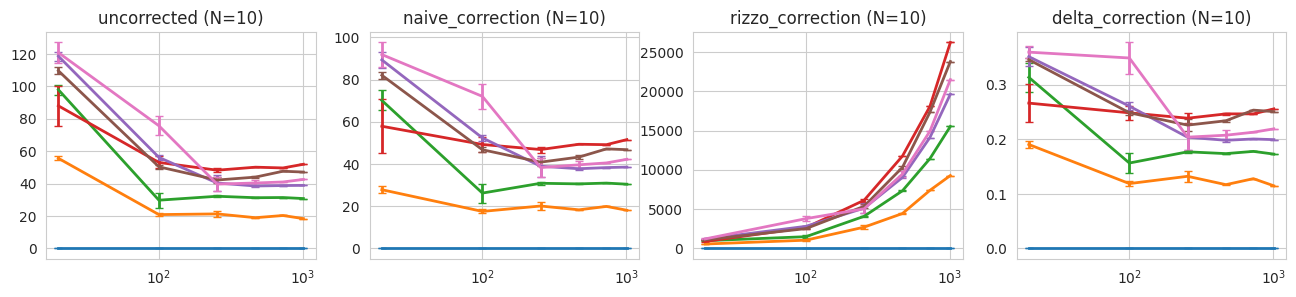

In [15]:
# plot with error bars (std)
flavors = ['uncorrected', 'naive_correction', 'rizzo_correction', 'delta_correction']
M = len(flavors)
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(1, M, figsize=[4*M, 3], dpi=100)
for ax, key in zip(axs, flavors):
    for p in df.perturbation.unique():
        mask = means.perturbation==p
        ax.errorbar(means[mask].N_cells, means[mask][key], yerr=sdevs[mask][key], linewidth=2, capsize=3)
    ax.set_xscale('log')
    ax.set_title(f'{key} (N={N_resample})')
pl.show()

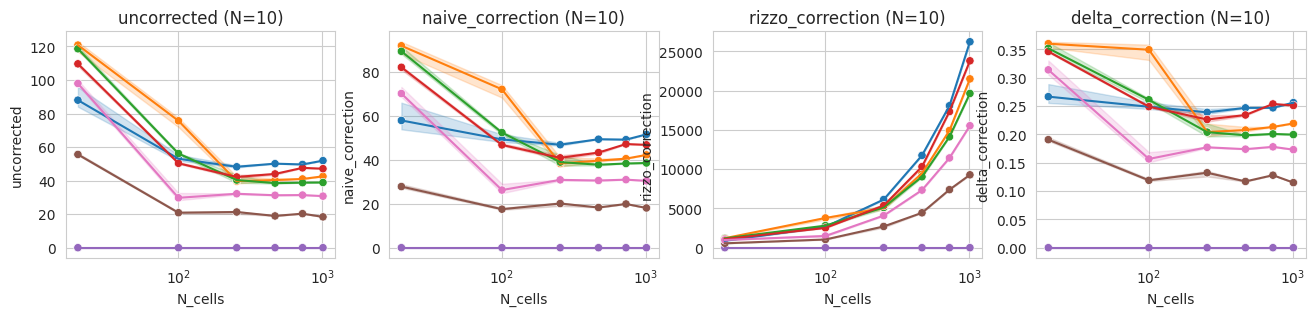

In [16]:
# plot with 95% CIs
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(1,M, figsize=[4*M,3], dpi=100)
for ax, key in zip(axs, flavors):
    sns.lineplot(data=df, x='N_cells', y=key, hue='perturbation', ax=ax, legend=False)
    sns.scatterplot(data=means, x='N_cells', y=key, hue='perturbation', ax=ax, legend=False)
    ax.set_xscale('log')
    ax.set_title(f'{key} (N={N_resample})')
pl.show()

- 1/N**2 uncorrected
- 1/N(N-1) "naive" correction